## Libraries

In [405]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
from bs4 import BeautifulSoup
import nltk, string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn.metrics import auc, roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import warnings
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from nltk.stem import PorterStemmer
import umap
import umap.plot
import joblib

## Read Data

In [260]:
df = pandas.read_csv("Project1-ClassificationDataset.csv")

In [261]:
print(df.shape)

(3476, 8)


In [263]:
df["num_char"] = df["full_text"].apply(len)

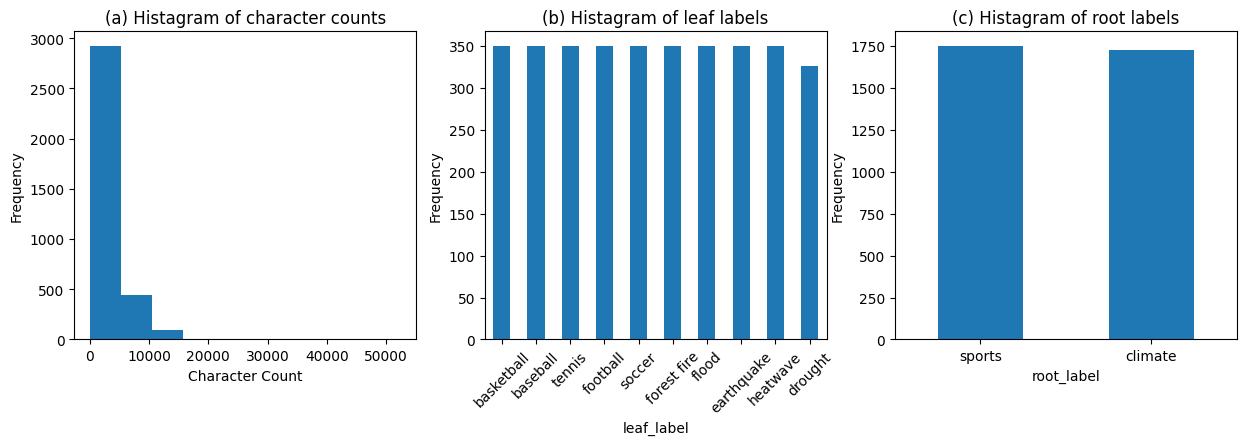

In [331]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
counts, bins = np.histogram(df["num_char"])

ax1.hist(bins[:-1], bins, weights=counts)
ax1.set_title("(a) Histagram of character counts")
ax1.set_xlabel("Character Count")
ax1.set_ylabel("Frequency")

df["leaf_label"].value_counts().plot(kind='bar', rot=45, ax=ax2)
ax2.set_title("(b) Histagram of leaf labels")
ax2.set_ylabel("Frequency")

df["root_label"].value_counts().plot(kind='bar', rot=0, ax=ax3)
ax3.set_title("(c) Histagram of root labels")
ax3.set_ylabel("Frequency")

plt.savefig("image/Q1.jpg", bbox_inches='tight')
plt.show()

## Binary Classification

In [265]:
np.random.seed(42)
random.seed(42)

#### Split Train/Test Set

In [550]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2, random_state=42)

In [551]:
print(len(train), len(test))

2780 696


#### Feature Extraction

In [519]:
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

def clean_html(html):

    # parse html content
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(['style', 'script', 'code', 'a']):
        # Remove tags
        data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [552]:
train["full_text"] = train["full_text"].apply(clean)
test["full_text"] = test["full_text"].apply(clean)
train["full_text"] = train["full_text"].apply(clean_html)
test["full_text"] = test["full_text"].apply(clean_html)

In [521]:
lemmatizer = WordNetLemmatizer()
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatize(text):
    text = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]
    text = [word for word in text if word not in string.punctuation] # remove punctuation
    words = []
    for word in text:
        try:
            float(word)
        except ValueError:
            words.append(word)
    return " ".join(words)

In [553]:
train["full_text"] = train["full_text"].apply(lemmatize)
test["full_text"] = test["full_text"].apply(lemmatize)

In [554]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=3)

X_train = vectorizer.fit_transform(train["full_text"])
X_test = vectorizer.transform(test["full_text"])

print(X_train.shape)
print(X_test.shape)

(2780, 13731)
(696, 13731)


#### Dimensionality Reduction

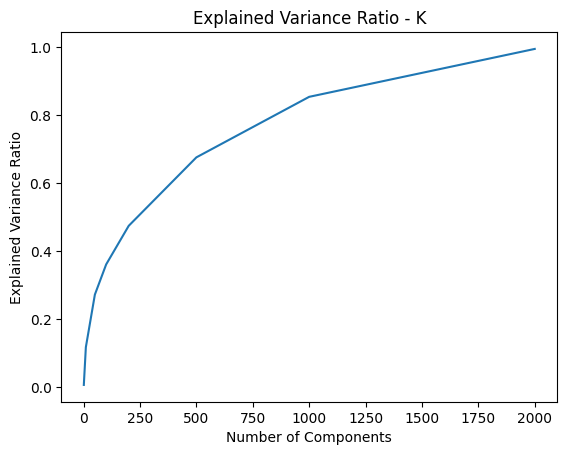

In [524]:
explained_variance_ratio = []
ks = [1, 10, 50, 100, 200, 500, 1000, 2000]
for k in ks:
    LSI = TruncatedSVD(n_components=k, random_state=42)
    X_train_LSI_k = LSI.fit_transform(X_train)
    explained_variance_ratio.append(LSI.explained_variance_ratio_.sum())

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ks, explained_variance_ratio)
ax.set_title("Explained Variance Ratio - K")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance Ratio")
# for xy in zip(ks, expected_variance_ratio):
#     ax.annotate('(%s, %.2f)' % xy, xy=xy, textcoords='data')
plt.savefig('image/Q4-1.jpg')
plt.show()

In [555]:
LSI = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = LSI.fit_transform(X_train)
X_test_LSI = LSI.transform(X_test)
U,Sig,VT = randomized_svd(X_train,n_components=50,random_state=42)
Sig = np.diag(Sig)
print("MSE Error for LSI: ", np.sum(np.array(X_train - U.dot(Sig).dot(VT))**2))


nmf = NMF(n_components=50, init='random', random_state=42)
X_train_NMF = nmf.fit_transform(X_train)
X_test_NMF = nmf.transform(X_test)
H = nmf.components_
print("MSE Error for NMF: ", np.sum(np.array(X_train - X_train_NMF.dot(H))**2))

MSE Error for LSI:  1953.4076220707805
MSE Error for NMF:  1986.9603516507825


In [526]:
print(U.shape, Sig.shape, VT.shape, X_train_LSI.shape)

(2780, 50) (50, 50) (50, 13909) (2780, 50)


#### Classification

##### SVM

In [556]:
labels = {"sports" : 0, "climate" : 1}
Y_train = np.float64([labels[i] for i in train.root_label])
Y_test = np.float64([labels[i] for i in test.root_label])

clf_hard = svm.SVC(kernel='linear',C=1000,random_state=42)
clf_soft = svm.SVC(kernel='linear',C=0.0001,random_state=42)
clf_hard.fit(X_train_LSI, Y_train)
clf_soft.fit(X_train_LSI, Y_train)
dec_hard = clf_hard.decision_function(X_test_LSI)
dec_soft = clf_soft.decision_function(X_test_LSI)
pred_hard = clf_hard.predict(X_test_LSI)
pred_soft = clf_soft.predict(X_test_LSI)

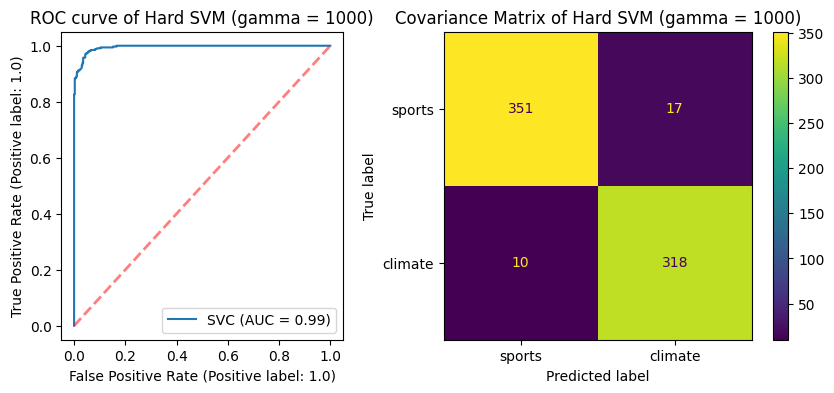

In [557]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_hard, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of Hard SVM (gamma = 1000)")
ConfusionMatrixDisplay.from_estimator(clf_hard, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of Hard SVM (gamma = 1000)")
plt.savefig("image/Q5-1.jpg", bbox_inches='tight')
plt.show()

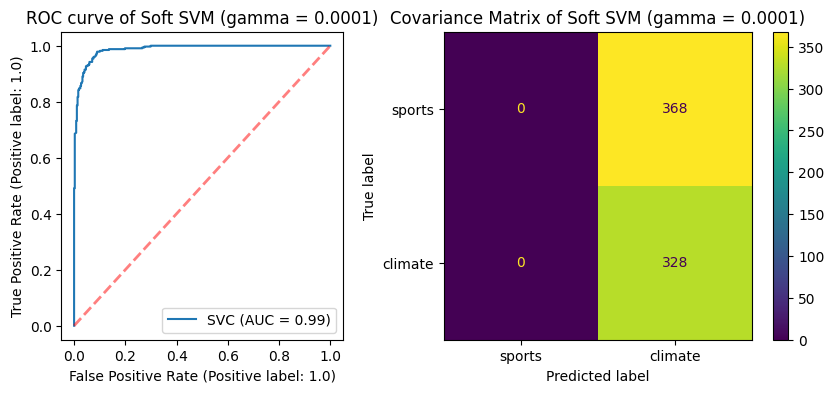

In [558]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_soft, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of Soft SVM (gamma = 0.0001)")
ConfusionMatrixDisplay.from_estimator(clf_soft, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of Soft SVM (gamma = 0.0001)")
plt.savefig("image/Q5-2.jpg", bbox_inches='tight')
plt.show()

In [559]:
print("Hard SVM")
print("Accuracy:", accuracy_score(Y_test, pred_hard))
print("Recall:", recall_score(Y_test, pred_hard))
print("Precision:", precision_score(Y_test, pred_hard, zero_division=0))
print("F1-Score:", f1_score(Y_test, pred_hard, zero_division=0))
print("\nSoft SVM")
print("Accuracy:", accuracy_score(Y_test, pred_soft))
print("Recall:", recall_score(Y_test, pred_soft))
print("Precision:", precision_score(Y_test, pred_soft, zero_division=0))
print("F1-Score:", f1_score(Y_test, pred_soft, zero_division=0))

Hard SVM
Accuracy: 0.9612068965517241
Recall: 0.9695121951219512
Precision: 0.9492537313432836
F1-Score: 0.9592760180995474

Soft SVM
Accuracy: 0.47126436781609193
Recall: 1.0
Precision: 0.47126436781609193
F1-Score: 0.640625


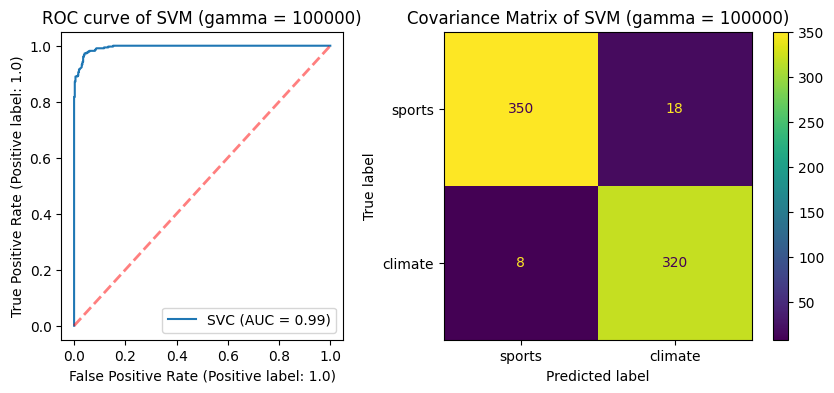

In [560]:
clf_1e5 = svm.SVC(kernel='linear',C=100000,random_state=42)
clf_1e5.fit(X_train_LSI, Y_train)
pred_1e5 = clf_1e5.predict(X_test_LSI)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_1e5, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of SVM (gamma = 100000)")
ConfusionMatrixDisplay.from_estimator(clf_1e5, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of SVM (gamma = 100000)")
plt.savefig("image/Q5-3.jpg", bbox_inches='tight')
plt.show()

In [561]:
print("Gamma = 100000 SVM")
print("Accuracy:", accuracy_score(Y_test, pred_1e5))
print("Recall:", recall_score(Y_test, pred_1e5))
print("Precision:", precision_score(Y_test, pred_1e5, zero_division=0))
print("F1-Score:", f1_score(Y_test, pred_1e5, zero_division=0))

Gamma = 100000 SVM
Accuracy: 0.9626436781609196
Recall: 0.975609756097561
Precision: 0.9467455621301775
F1-Score: 0.960960960960961


In [562]:
clf_cv = svm.SVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000],  'kernel': ['linear']}
grid = GridSearchCV(clf_cv,param_grid,cv=5,scoring='accuracy')
grid.fit(X_train_LSI,Y_train)
pred_cv = grid.best_estimator_.predict(X_test_LSI)

print('Best Value of gamma:',grid.best_params_['C']) 
for l, n in zip(param_grid['C'],grid.cv_results_['mean_test_score']):
    print(f'Gamma: {l}\t',f'Avg. Validation Accuracy: {n}')

Best Value of gamma: 10000
Gamma: 0.001	 Avg. Validation Accuracy: 0.5028776978417266
Gamma: 0.01	 Avg. Validation Accuracy: 0.7791366906474819
Gamma: 0.1	 Avg. Validation Accuracy: 0.9370503597122302
Gamma: 1	 Avg. Validation Accuracy: 0.9485611510791367
Gamma: 10	 Avg. Validation Accuracy: 0.9535971223021583
Gamma: 100	 Avg. Validation Accuracy: 0.9535971223021583
Gamma: 1000	 Avg. Validation Accuracy: 0.9535971223021583
Gamma: 10000	 Avg. Validation Accuracy: 0.9543165467625899
Gamma: 100000	 Avg. Validation Accuracy: 0.953956834532374
Gamma: 1000000	 Avg. Validation Accuracy: 0.9543165467625899


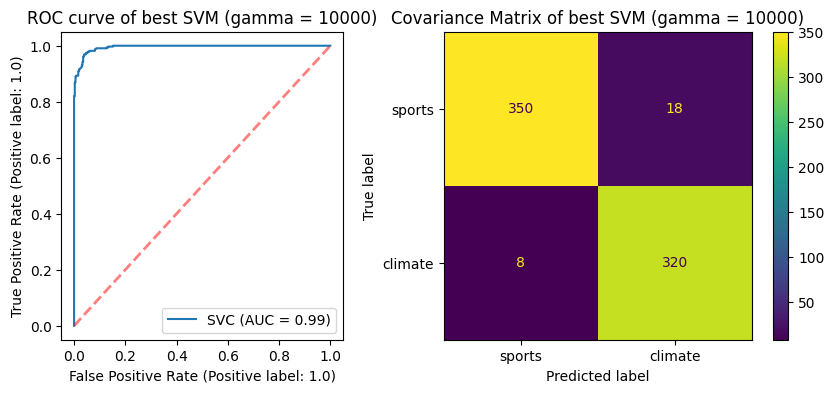

In [565]:
pred_best = grid.best_estimator_.predict(X_test_LSI)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(grid.best_estimator_, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of best SVM (gamma = 10000)")
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of best SVM (gamma = 10000)")
plt.savefig("image/Q5-4.jpg", bbox_inches='tight')
plt.show()

In [566]:
print("Best SVM")
print("Accuracy:", accuracy_score(Y_test, pred_best))
print("Recall:", recall_score(Y_test, pred_best))
print("Precision:", precision_score(Y_test, pred_best, zero_division=0))
print("F1-Score:", f1_score(Y_test, pred_best, zero_division=0))

Best SVM
Accuracy: 0.9626436781609196
Recall: 0.975609756097561
Precision: 0.9467455621301775
F1-Score: 0.960960960960961


##### Logistic Regression

In [310]:
clf_lr_wo = LogisticRegression(C=1000000,random_state=42,max_iter=100000)
clf_lr_wo.fit(X_train_LSI,Y_train)
pred_lr_wo = clf_lr_wo.predict(X_test_LSI)

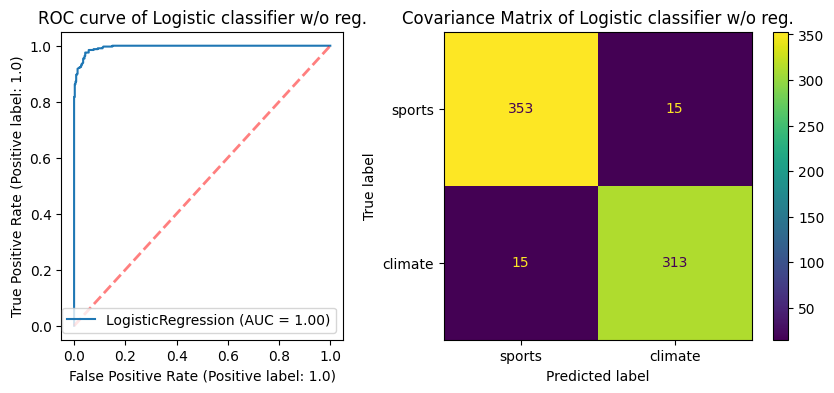

In [322]:
pred_best = grid.best_estimator_.predict(X_test_LSI)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_lr_wo, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of Logistic classifier w/o reg.")
ConfusionMatrixDisplay.from_estimator(clf_lr_wo, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of Logistic classifier w/o reg.")
plt.savefig("image/Q6.jpg", bbox_inches='tight')
plt.show()

In [323]:
print("Logistic Classifier - w/o regularization")
print("Accuracy:", accuracy_score(Y_test,pred_lr_wo))
print("Recall:", recall_score(Y_test,pred_lr_wo))
print("Precision:", precision_score(Y_test,pred_lr_wo))
print("F1-Score:", f1_score(Y_test,pred_lr_wo))

Logistic Classifier - w/o regularization
Accuracy: 0.9568965517241379
Recall: 0.9542682926829268
Precision: 0.9542682926829268
F1-Score: 0.9542682926829268


In [316]:
clf_lr_l1 = LogisticRegression(penalty='l1',random_state=42,solver='liblinear',max_iter=100000)
param_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
grid_l1 = GridSearchCV(clf_lr_l1,param_grid,cv=5,scoring='accuracy')
grid_l1.fit(X_train_LSI,Y_train)
pred_cv_lr_l1 = grid_l1.best_estimator_.predict(X_test_LSI)

clf_lr_l2 = LogisticRegression(penalty='l2',solver='liblinear',random_state=42)
grid_l2 = GridSearchCV(clf_lr_l2,param_grid,cv=5,scoring='accuracy')
grid_l2.fit(X_train_LSI,Y_train)
pred_cv_lr_l2 = grid_l2.best_estimator_.predict(X_test_LSI)

In [342]:
print('Best Value of L1 Regularization Parameter:',grid_l1.best_params_['C']) 
for l, n in zip(param_grid['C'],grid_l1.cv_results_['mean_test_score']):
    print(f'L1 Reg. Param.: {l}\t',f'Avg. Validation Accuracy: {n}')
    
print('Best Value of L2 Regularization Parameter:',grid_l2.best_params_['C']) 
for l, n in zip(param_grid['C'],grid_l2.cv_results_['mean_test_score']):
    print(f'L2 Reg. Param.: {l}\t',f'Avg. Validation Accuracy: {n}')

Best Value of L1 Regularization Parameter: 10
L1 Reg. Param.: 1e-05	 Avg. Validation Accuracy: 0.4971223021582734
L1 Reg. Param.: 0.0001	 Avg. Validation Accuracy: 0.4971223021582734
L1 Reg. Param.: 0.001	 Avg. Validation Accuracy: 0.4971223021582734
L1 Reg. Param.: 0.01	 Avg. Validation Accuracy: 0.4971223021582734
L1 Reg. Param.: 0.1	 Avg. Validation Accuracy: 0.9276978417266187
L1 Reg. Param.: 1	 Avg. Validation Accuracy: 0.9507194244604316
L1 Reg. Param.: 10	 Avg. Validation Accuracy: 0.9561151079136693
L1 Reg. Param.: 100	 Avg. Validation Accuracy: 0.95431654676259
L1 Reg. Param.: 1000	 Avg. Validation Accuracy: 0.95431654676259
L1 Reg. Param.: 10000	 Avg. Validation Accuracy: 0.95431654676259
L1 Reg. Param.: 100000	 Avg. Validation Accuracy: 0.95431654676259
Best Value of L2 Regularization Parameter: 100
L2 Reg. Param.: 1e-05	 Avg. Validation Accuracy: 0.8640287769784173
L2 Reg. Param.: 0.0001	 Avg. Validation Accuracy: 0.8715827338129495
L2 Reg. Param.: 0.001	 Avg. Validation Ac

In [343]:
print("Best Logistic Classifer with L1 regularization")
print("Accuracy:", accuracy_score(Y_test,pred_cv_lr_l1 ))
print("Recall:", recall_score(Y_test,pred_cv_lr_l1 ))
print("Precision:", precision_score(Y_test,pred_cv_lr_l1 ))
print("F1-Score:", f1_score(Y_test,pred_cv_lr_l1 ))
print("\nBest Logistic Classifer with L2 regularization")
print("Accuracy:", accuracy_score(Y_test,pred_cv_lr_l2 ))
print("Recall:", recall_score(Y_test,pred_cv_lr_l2 ))
print("Precision:", precision_score(Y_test,pred_cv_lr_l2 ))
print("F1-Score:", f1_score(Y_test,pred_cv_lr_l2 ))

Best Logistic Classifer with L1 regularization
Accuracy: 0.9612068965517241
Recall: 0.9603658536585366
Precision: 0.9574468085106383
F1-Score: 0.9589041095890412

Best Logistic Classifer with L2 regularization
Accuracy: 0.9568965517241379
Recall: 0.9542682926829268
Precision: 0.9542682926829268
F1-Score: 0.9542682926829268


##### Naive Bayes Model

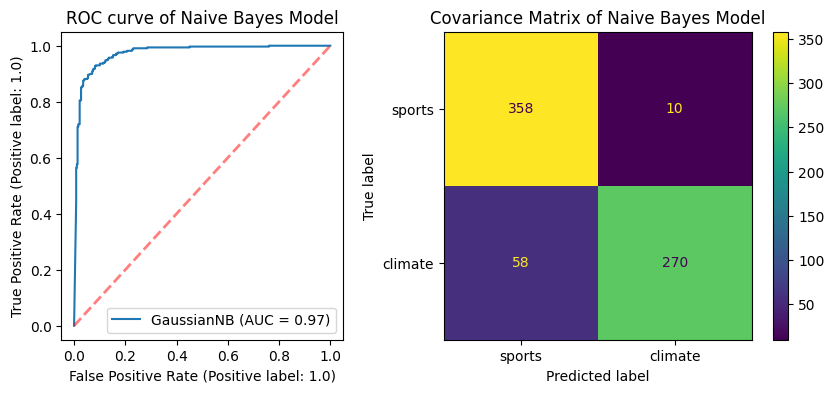

In [344]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train_LSI, Y_train)
pred_gnb = clf_gnb.predict(X_test_LSI)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_gnb, X_test_LSI, Y_test, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of Naive Bayes Model")
ConfusionMatrixDisplay.from_estimator(clf_gnb, X_test_LSI, Y_test, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of Naive Bayes Model")
plt.savefig("image/Q7.jpg", bbox_inches='tight')
plt.show()

In [346]:
print("Gaussian Naive Bayes Model")
print("Accuracy:", accuracy_score(Y_test,pred_gnb ))
print("Recall:", recall_score(Y_test,pred_gnb ))
print("Precision:", precision_score(Y_test,pred_gnb ))
print("F1-Score:", f1_score(Y_test,pred_gnb ))

Gaussian Naive Bayes Model
Accuracy: 0.9022988505747126
Recall: 0.823170731707317
Precision: 0.9642857142857143
F1-Score: 0.8881578947368421


#### Grid Search of Parameters

In [347]:
lemmatizer = WordNetLemmatizer()
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemma(text):
    text = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]
    words = []
    for word in text:
        if (not any(char in word for char in string.punctuation) and not any(char.isdigit() for char in word)):
            words.append(word.lower())
    return words

stemmer = PorterStemmer()
def stemming(text):
    text = nltk.word_tokenize(text)
    text = [stemmer.stem(word) for word in text]
    words = []
    for word in text:
        if (not any(char in word for char in string.punctuation) and not any(char.isdigit() for char in word)):
            words.append(word.lower())
    return words

# def lemmatized(sentence):
#     lemmatized_sen = []
#     lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
#                   for word, tag in pos_tag(nltk.word_tokenize(sentence))]
#     for lemma in lemma_list:
#         if (not any(char in lemma for char in string.punctuation) and not any(char.isdigit() for char in lemma)):
#             lemmatized_sen.append(lemma.lower())
#     return lemmatized_sen


In [350]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('reduce_dim', None),
    ('clf', None),
])

param_grid = [
    {
        'vect__min_df': (3,5),
        'vect__analyzer': (lemma,stemming),
        'reduce_dim': (TruncatedSVD(n_components=5, random_state=42),TruncatedSVD(n_components=30, random_state=42),TruncatedSVD(n_components=80, random_state=42)
                       , NMF(n_components=5, init='random', random_state=42), NMF(n_components=30, init='random', random_state=42), NMF(n_components=80, init='random', random_state=42)), 
        'clf': (svm.SVC(kernel='linear',C=10,random_state=42),
                GaussianNB(),
                LogisticRegression(C=10,penalty='l1',random_state=42,solver='liblinear',max_iter=100000),
                LogisticRegression(C=100,penalty='l2',random_state=42,solver='liblinear')),  
    }
]


In [351]:
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
train["full_text"] = train["full_text"].apply(clean).apply(clean_html)
test["full_text"] = test["full_text"].apply(clean).apply(clean_html)
labels = {"sports" : 0, "climate" : 1}
X_train = train.full_text.to_list()
X_test = test.full_text.to_list()
Y_train = np.float64([labels[i] for i in train.root_label])
Y_test = np.float64([labels[i] for i in test.root_label])

In [353]:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

grid_gs = GridSearchCV(pipeline,cv=5,param_grid=param_grid,scoring='accuracy', verbose=10)
## Train & Save
grid_gs.fit(X_train, Y_train)
joblib.dump(grid_gs, 'Project1_grid_search.pkl')
## Load
# grid_gs = joblib.load("Project1_grid_search.pkl")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5; 1/96] START clf=SVC(C=10, kernel='linear', random_state=42), reduce_dim=TruncatedSVD(n_components=5, random_state=42), vect__analyzer=<function lemma at 0x164cd4860>, vect__min_df=3
[CV 1/5; 1/96] END clf=SVC(C=10, kernel='linear', random_state=42), reduce_dim=TruncatedSVD(n_components=5, random_state=42), vect__analyzer=<function lemma at 0x164cd4860>, vect__min_df=3;, score=0.897 total time=  31.7s
[CV 2/5; 1/96] START clf=SVC(C=10, kernel='linear', random_state=42), reduce_dim=TruncatedSVD(n_components=5, random_state=42), vect__analyzer=<function lemma at 0x164cd4860>, vect__min_df=3
[CV 2/5; 1/96] END clf=SVC(C=10, kernel='linear', random_state=42), reduce_dim=TruncatedSVD(n_components=5, random_state=42), vect__analyzer=<function lemma at 0x164cd4860>, vect__min_df=3;, score=0.908 total time=  31.4s
[CV 3/5; 1/96] START clf=SVC(C=10, kernel='linear', random_state=42), reduce_dim=TruncatedSVD(n_components=5, ra

['Project1_grid_search.pkl']

In [388]:
results = pandas.DataFrame(grid_gs.cv_results_)
results.sort_values(by='rank_test_score', inplace=True, ignore_index=True)

In [381]:
for i in range(5):
    print(results.loc[i, 'params'])

{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function lemma at 0x164cd4860>, 'vect__min_df': 3}
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function lemma at 0x164cd4860>, 'vect__min_df': 5}
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function stemming at 0x164cd5620>, 'vect__min_df': 5}
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function stemming at 0x164cd5620>, 'vect__min_df': 3}
{'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42,
                   solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=

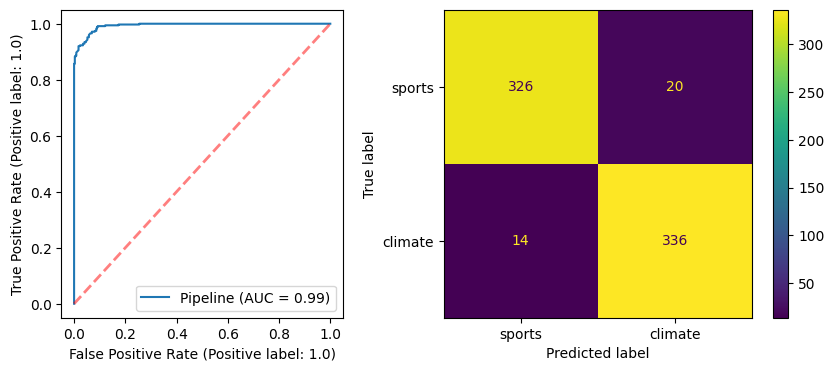

No. 1 Performance Parameter
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function lemma at 0x164cd4860>, 'vect__min_df': 3}
Accuracy: 0.9511494252873564
Recall: 0.96
Precision: 0.9438202247191011
F1-Score: 0.951841359773371


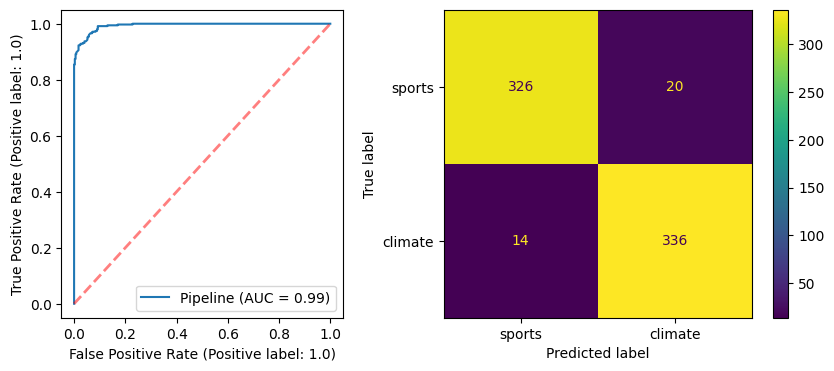

No. 2 Performance Parameter
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function lemma at 0x164cd4860>, 'vect__min_df': 5}
Accuracy: 0.9511494252873564
Recall: 0.96
Precision: 0.9438202247191011
F1-Score: 0.951841359773371


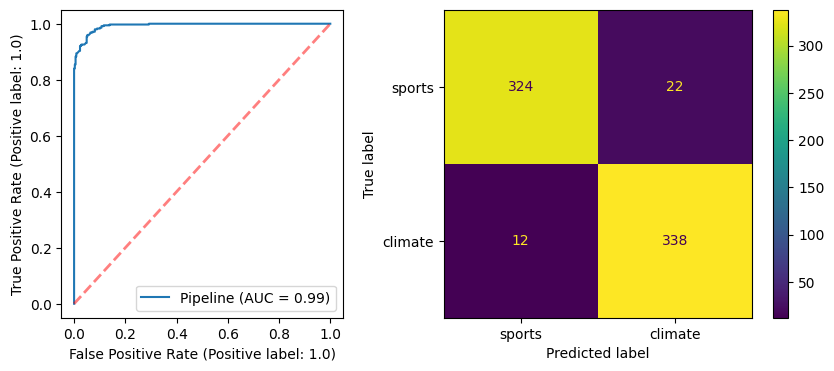

No. 3 Performance Parameter
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function stemming at 0x164cd5620>, 'vect__min_df': 5}
Accuracy: 0.9511494252873564
Recall: 0.9657142857142857
Precision: 0.9388888888888889
F1-Score: 0.952112676056338


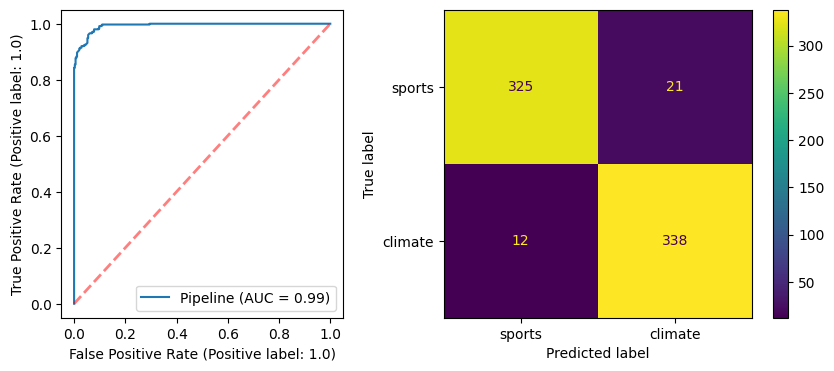

No. 4 Performance Parameter
{'clf': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function stemming at 0x164cd5620>, 'vect__min_df': 3}
Accuracy: 0.9525862068965517
Recall: 0.9657142857142857
Precision: 0.9415041782729805
F1-Score: 0.9534555712270805


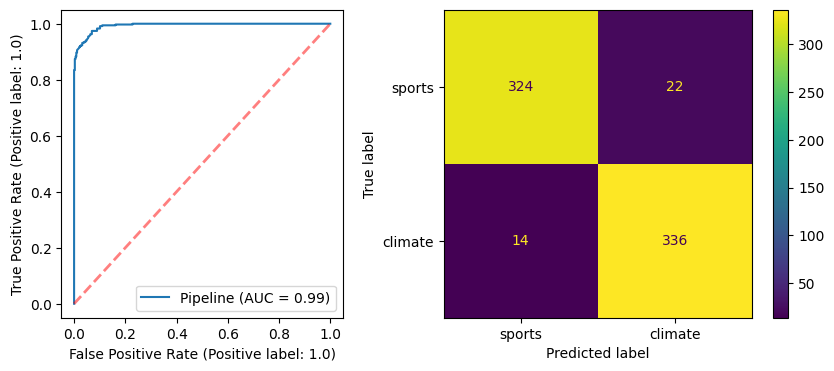

No. 5 Performance Parameter
{'clf': LogisticRegression(C=10, max_iter=100000, penalty='l1', random_state=42,
                   solver='liblinear'), 'reduce_dim': TruncatedSVD(n_components=80, random_state=42), 'vect__analyzer': <function lemma at 0x164cd4860>, 'vect__min_df': 5}
Accuracy: 0.9482758620689655
Recall: 0.96
Precision: 0.9385474860335196
F1-Score: 0.9491525423728814


In [383]:
for i in range(5):
    params = results.loc[i, 'params']
    clf = grid_gs.best_estimator_.set_params(**params)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
    RocCurveDisplay.from_estimator(clf, X_test, Y_test, ax=ax1)
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
    ConfusionMatrixDisplay.from_estimator(clf, X_test, Y_test, ax=ax2, display_labels=['sports','climate'])
    plt.savefig("image/Q8-{}.jpg".format(i+1), bbox_inches='tight')
    plt.show()

    print("No. {} Performance Parameter".format(i+1))
    print(params)
    print("Accuracy:", accuracy_score(Y_test,pred ))
    print("Recall:", recall_score(Y_test,pred ))
    print("Precision:", precision_score(Y_test,pred ))
    print("F1-Score:", f1_score(Y_test,pred ))

## Multiclass Classification

In [390]:
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 
                    3:"football", 4:"soccer", 5:"forest fire", 6:"flood", 
                    7:"earthquake", 8:"drought", 9:"heatwave"}
map_class_to_row = {v:k for k,v in map_row_to_class.items()}

In [391]:
train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

train["full_text"] = train["full_text"].apply(clean)
test["full_text"] = test["full_text"].apply(clean)
train["full_text"] = train["full_text"].apply(clean_html)
test["full_text"] = test["full_text"].apply(clean_html)
train["full_text"] = train["full_text"].apply(lemmatize)
test["full_text"] = test["full_text"].apply(lemmatize)

In [392]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=3)

X_train_mc = vectorizer.fit_transform(train["full_text"])
X_test_mc = vectorizer.transform(test["full_text"])
Y_train_mc = np.float64([map_class_to_row[i] for i in train.leaf_label])
Y_test_mc = np.float64([map_class_to_row[i] for i in test.leaf_label])

In [393]:
LSI = TruncatedSVD(n_components=50, random_state=42)
X_train_mc = LSI.fit_transform(X_train_mc)
X_test_mc = LSI.transform(X_test_mc)

In [394]:
clf_gnb_mc = GaussianNB()
clf_gnb_mc.fit(X_train_mc, Y_train_mc)
pred_gnb_mc = clf_gnb_mc.predict(X_test_mc)

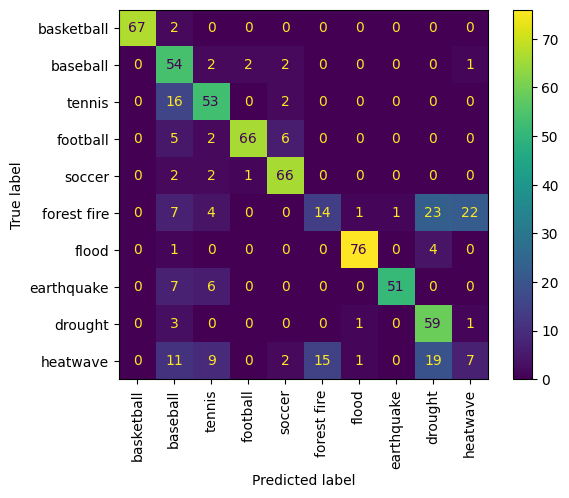

In [397]:
fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_gnb_mc, X_test_mc, Y_test_mc, ax=ax, display_labels=map_class_to_row.keys())
plt.xticks(rotation=90)
fig.savefig("image/Q9-1.jpg".format(i+1), bbox_inches='tight')
plt.show()

In [398]:
print("Naive Bayes classification")
print("Accuracy:", accuracy_score(Y_test_mc,pred_gnb_mc ))
print("Recall:", recall_score(Y_test_mc,pred_gnb_mc,average='weighted'))
print("Precision:", precision_score(Y_test_mc,pred_gnb_mc,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc,pred_gnb_mc,average='weighted'))

Naive Bayes classification
Accuracy: 0.7370689655172413
Recall: 0.7370689655172413
Precision: 0.7316826867367027
F1-Score: 0.7157192897405935


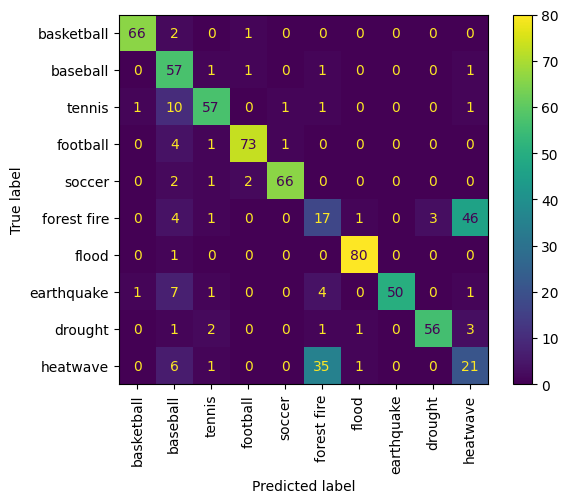

One VS One SVM Classification
Accuracy: 0.7801724137931034
Recall: 0.7801724137931034
Precision: 0.7931093828813383
F1-Score: 0.7815660293765022


In [399]:
clf_svm_mc_oo = OneVsOneClassifier(svm.SVC(random_state=42))
clf_svm_mc_oo.fit(X_train_mc, Y_train_mc)
pred_svm_mc_oo = clf_svm_mc_oo.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_oo, X_test_mc, Y_test_mc, ax=ax, display_labels=map_class_to_row.keys())
plt.xticks(rotation=90)
fig.savefig("image/Q9-2.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS One SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc,pred_svm_mc_oo ))
print("Recall:", recall_score(Y_test_mc,pred_svm_mc_oo,average='weighted'))
print("Precision:", precision_score(Y_test_mc,pred_svm_mc_oo,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc,pred_svm_mc_oo,average='weighted'))

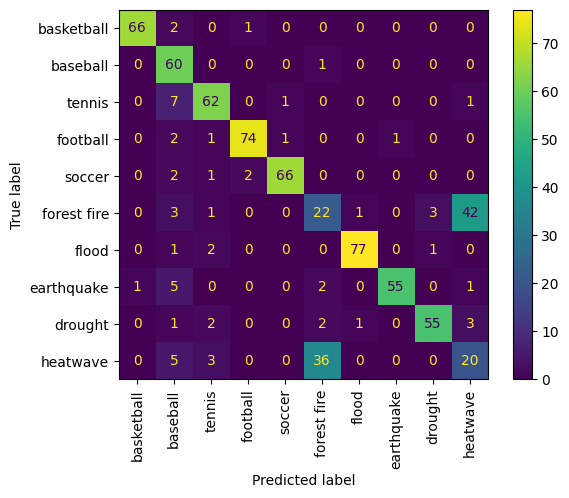

One VS Rest SVM Classification
Accuracy: 0.8002873563218391
Recall: 0.8002873563218391
Precision: 0.8063917406769971
F1-Score: 0.8001599244030245


In [408]:
clf_svm_mc_or = OneVsRestClassifier(svm.SVC(random_state=42, class_weight='balanced'))
clf_svm_mc_or.fit(X_train_mc, Y_train_mc)
pred_svm_mc_or = clf_svm_mc_or.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_or, X_test_mc, Y_test_mc, ax=ax, display_labels=map_class_to_row.keys())
plt.xticks(rotation=90)
fig.savefig("image/Q9-3.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS Rest SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc,pred_svm_mc_or ))
print("Recall:", recall_score(Y_test_mc,pred_svm_mc_or,average='weighted'))
print("Precision:", precision_score(Y_test_mc,pred_svm_mc_or,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc,pred_svm_mc_or,average='weighted'))

In [414]:
new_map = map_class_to_row.copy()
new_map['heatwave'] = 5
new_labels = [i for i in map_class_to_row]
new_labels.pop()
new_labels[5] = 'heat'

In [415]:
Y_train_mc_new = np.float64([new_map[i] for i in train.leaf_label])
Y_test_mc_new = np.float64([new_map[i] for i in test.leaf_label])

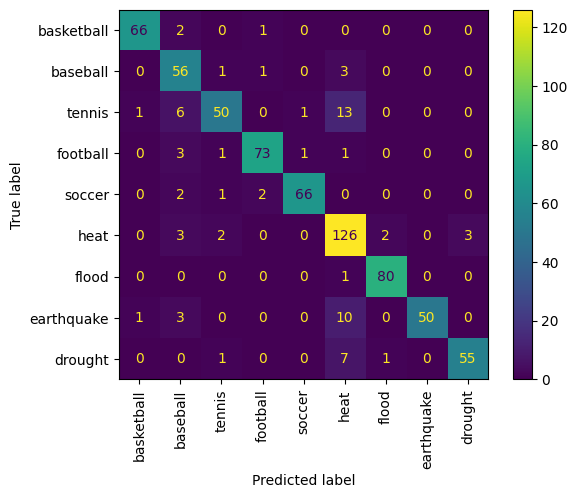

One VS One SVM Classification
Accuracy: 0.8936781609195402
Recall: 0.8936781609195402
Precision: 0.9036130856099716
F1-Score: 0.8940323479437672


In [421]:
clf_svm_mc_oo_new = OneVsOneClassifier(svm.SVC(random_state=42))
clf_svm_mc_oo_new.fit(X_train_mc, Y_train_mc_new)
pred_svm_mc_oo_new = clf_svm_mc_oo_new.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_oo_new, X_test_mc, Y_test_mc_new, ax=ax, display_labels=new_labels)
plt.xticks(rotation=90)
fig.savefig("image/Q9-4.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS One SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc_new,pred_svm_mc_oo_new ))
print("Recall:", recall_score(Y_test_mc_new,pred_svm_mc_oo_new,average='weighted'))
print("Precision:", precision_score(Y_test_mc_new,pred_svm_mc_oo_new,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc_new,pred_svm_mc_oo_new,average='weighted'))

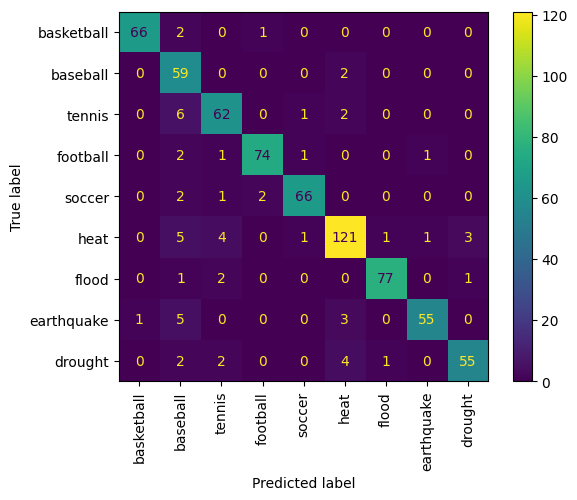

One VS One SVM Classification
Accuracy: 0.9123563218390804
Recall: 0.9123563218390804
Precision: 0.9207195895223221
F1-Score: 0.9141609725466135


In [430]:
clf_svm_mc_or_new = OneVsRestClassifier(svm.SVC(random_state=42, class_weight='balanced'))
clf_svm_mc_or_new.fit(X_train_mc, Y_train_mc_new)
pred_svm_mc_or_new = clf_svm_mc_or_new.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_or_new, X_test_mc, Y_test_mc_new, ax=ax, display_labels=new_labels)
plt.xticks(rotation=90)
fig.savefig("image/Q9-5.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS One SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc_new,pred_svm_mc_or_new ))
print("Recall:", recall_score(Y_test_mc_new,pred_svm_mc_or_new,average='weighted'))
print("Precision:", precision_score(Y_test_mc_new,pred_svm_mc_or_new,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc_new,pred_svm_mc_or_new,average='weighted'))

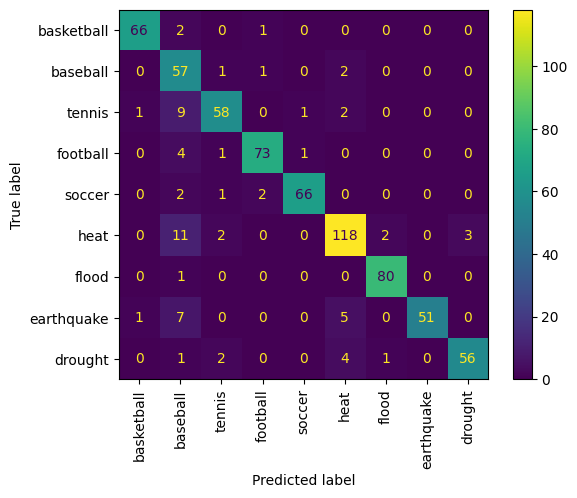

One VS One SVM Classification
Accuracy: 0.8979885057471264
Recall: 0.8979885057471264
Precision: 0.9144303640167214
F1-Score: 0.9016396804281083


In [431]:
clf_svm_mc_oo_bal = OneVsOneClassifier(svm.SVC(random_state=42, class_weight='balanced'))
clf_svm_mc_oo_bal.fit(X_train_mc, Y_train_mc_new)
pred_svm_mc_oo_bal = clf_svm_mc_oo_bal.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_oo_bal, X_test_mc, Y_test_mc_new, ax=ax, display_labels=new_labels)
plt.xticks(rotation=90)
fig.savefig("image/Q9-6.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS One SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc_new,pred_svm_mc_oo_bal ))
print("Recall:", recall_score(Y_test_mc_new,pred_svm_mc_oo_bal,average='weighted'))
print("Precision:", precision_score(Y_test_mc_new,pred_svm_mc_oo_bal,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc_new,pred_svm_mc_oo_bal,average='weighted'))

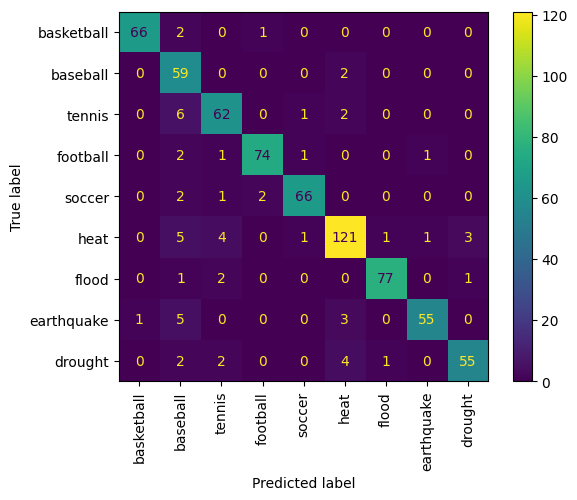

One VS One SVM Classification
Accuracy: 0.9123563218390804
Recall: 0.9123563218390804
Precision: 0.9207195895223221
F1-Score: 0.9141609725466135


In [432]:
clf_svm_mc_or_bal = OneVsRestClassifier(svm.SVC(random_state=42, class_weight='balanced'))
clf_svm_mc_or_bal.fit(X_train_mc, Y_train_mc_new)
pred_svm_mc_or_bal = clf_svm_mc_or_bal.predict(X_test_mc)

fig = plt.figure()
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_estimator(clf_svm_mc_or_bal, X_test_mc, Y_test_mc_new, ax=ax, display_labels=new_labels)
plt.xticks(rotation=90)
fig.savefig("image/Q9-7.jpg".format(i+1), bbox_inches='tight')
plt.show()

print("One VS One SVM Classification")
print("Accuracy:", accuracy_score(Y_test_mc_new,pred_svm_mc_or_bal ))
print("Recall:", recall_score(Y_test_mc_new,pred_svm_mc_or_bal,average='weighted'))
print("Precision:", precision_score(Y_test_mc_new,pred_svm_mc_or_bal,average='weighted'))
print("F1-Score:", f1_score(Y_test_mc_new,pred_svm_mc_or_bal,average='weighted'))

## Word Embedding

In [477]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [512]:
w = embeddings_dict['wife']
h = embeddings_dict['husband']
man = embeddings_dict['man']
woman = embeddings_dict['woman']
o = embeddings_dict['orange']
print(np.mean((w-h)**2))
print(np.mean((man-woman)**2))
print(np.mean((w-o)**2))

0.033117987
0.07533314
0.25043097


In [496]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def normalize(x):
    return x / np.linalg.norm(x)
def encode(keywords, embd):
    v = []
    for word in keywords[1:-1].split(", "):
        word = lemmatizer.lemmatize(word[1:-1])
        word = stemmer.stem(word)
        if word not in embd:
            continue
        v.append(normalize(embd[word]))
    out = np.mean(v, axis = 0)
    return out

In [500]:
train, test = train_test_split(df[["keywords","root_label"]], test_size=0.2)

In [501]:
train["encoding"] = train["keywords"].apply(encode, args = (embeddings_dict,))
test["encoding"] = test["keywords"].apply(encode, args = (embeddings_dict,))

In [502]:
X_train_glove = np.array(train["encoding"].values.tolist())
X_test_glove = np.array(test["encoding"].values.tolist())
labels = {"sports" : 0, "climate" : 1}
Y_train_glove = np.float64([labels[i] for i in train.root_label])
Y_test_glove = np.float64([labels[i] for i in test.root_label])

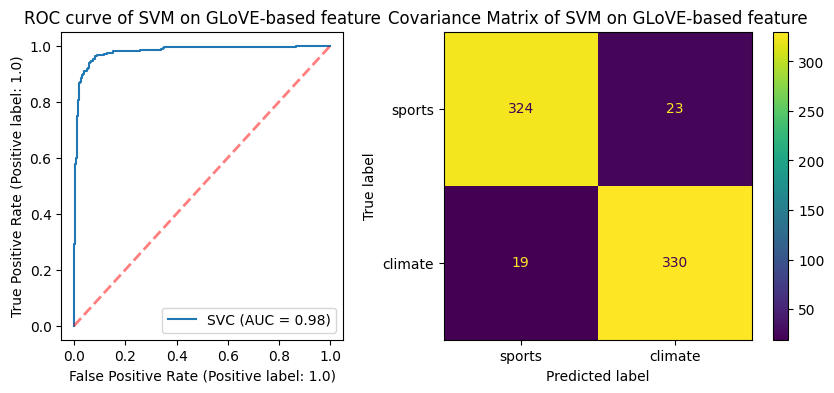

GloVe - SVM
Accuracy: 0.9396551724137931
Recall: 0.9455587392550143
Precision: 0.9348441926345609
F1-Score: 0.9401709401709402


In [503]:
clf_glove = svm.SVC(kernel='linear',C=10,random_state=42)
clf_glove.fit(X_train_glove, Y_train_glove)
pred_glove = clf_glove.predict(X_test_glove)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2,3]})
RocCurveDisplay.from_estimator(clf_glove, X_test_glove, Y_test_glove, ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.5)
ax1.set_title("ROC curve of SVM on GLoVE-based feature")
ConfusionMatrixDisplay.from_estimator(clf_glove, X_test_glove, Y_test_glove, ax=ax2, display_labels=['sports','climate'])
ax2.set_title("Covariance Matrix of SVM on GLoVE-based feature")
plt.savefig("image/Q11.jpg", bbox_inches='tight')
plt.show()

print("GloVe - SVM")
print("Accuracy:", accuracy_score(Y_test_glove,pred_glove ))
print("Recall:", recall_score(Y_test_glove,pred_glove ))
print("Precision:", precision_score(Y_test_glove,pred_glove ))
print("F1-Score:", f1_score(Y_test_glove,pred_glove ))

In [497]:
dimensions = [50, 100, 200, 300]
emd = {}
for d in dimensions:
    embeddings_dict_ = {}
    file_name = "glove.6B/glove.6B.{}d.txt".format(d)
    with open(file_name, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict_[word] = vector
    emd[d] = embeddings_dict_

In [498]:
train, test = train_test_split(df[["keywords","root_label"]], test_size=0.2, random_state=42)
Y_train_glove = np.float64([labels[i] for i in train.root_label])
Y_test_glove = np.float64([labels[i] for i in test.root_label])
labels = {"sports" : 0, "climate" : 1}
accuracy = []
for d in dimensions:
    X_train_glove = train["keywords"].apply(encode, args = (emd[d],))
    X_test_glove = test["keywords"].apply(encode, args = (emd[d],))
    X_train_glove = np.array(X_train_glove.values.tolist())
    X_test_glove = np.array(X_test_glove.values.tolist())

    clf_glove = svm.SVC(kernel='linear',C=1000,random_state=42)
    clf_glove.fit(X_train_glove, Y_train_glove)
    pred_glove = clf_glove.predict(X_test_glove)

    accuracy.append(accuracy_score(Y_test_glove,pred_glove ))

    print("GloVe - SVM, dimension = {}".format(d))
    print("Accuracy:", accuracy_score(Y_test_glove,pred_glove ))
    print("Recall:", recall_score(Y_test_glove,pred_glove ))
    print("Precision:", precision_score(Y_test_glove,pred_glove ))
    print("F1-Score:", f1_score(Y_test_glove,pred_glove ))
    print('\n')

GloVe - SVM, dimension = 50
Accuracy: 0.9209770114942529
Recall: 0.9298780487804879
Precision: 0.9050445103857567
F1-Score: 0.9172932330827068


GloVe - SVM, dimension = 100
Accuracy: 0.9238505747126436
Recall: 0.9298780487804879
Precision: 0.9104477611940298
F1-Score: 0.9200603318250378


GloVe - SVM, dimension = 200
Accuracy: 0.9425287356321839
Recall: 0.948170731707317
Precision: 0.9311377245508982
F1-Score: 0.9395770392749245


GloVe - SVM, dimension = 300
Accuracy: 0.9439655172413793
Recall: 0.9634146341463414
Precision: 0.9212827988338192
F1-Score: 0.9418777943368106




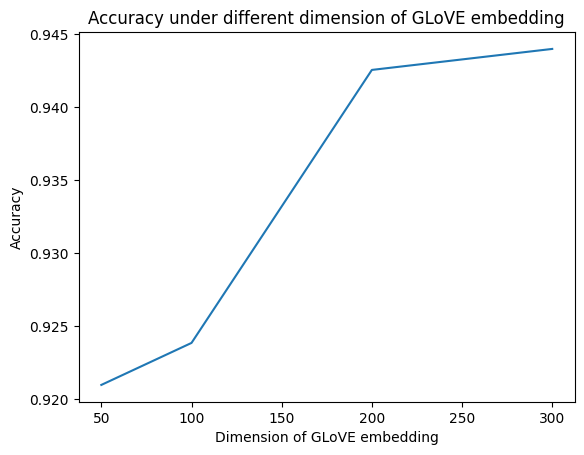

In [508]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dimensions, accuracy)
ax.set_title("Accuracy under different dimension of GLoVE embedding")
ax.set_xlabel("Dimension of GLoVE embedding")
ax.set_ylabel("Accuracy")
plt.savefig("image/Q12.jpg", bbox_inches='tight')
plt.show()

In [509]:
embedding = df["keywords"].apply(encode, args = (emd[300],))
embedding = np.array(embedding.values.tolist())

rand_vector = np.random.rand(len(df),300)
row_sums = np.linalg.norm(rand_vector, axis=1)
rand_vector = rand_vector / row_sums[:, np.newaxis]


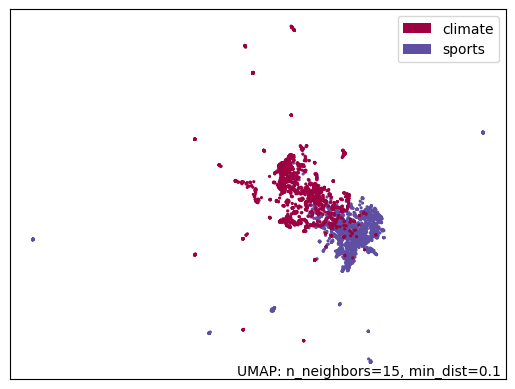

In [510]:
map_glove = umap.UMAP().fit(embedding)
fig = plt.figure()
ax = fig.add_subplot(111)
umap.plot.points(map_glove, labels=df['root_label'], ax=ax)
plt.savefig("image/Q13-1.jpg", bbox_inches='tight')
plt.show()

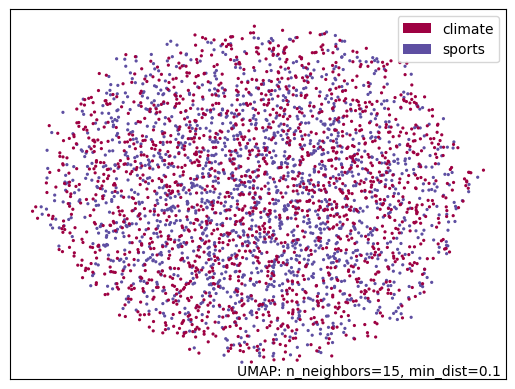

In [511]:
map_rand = umap.UMAP().fit(rand_vector)
fig = plt.figure()
ax = fig.add_subplot(111)
umap.plot.points(map_rand, labels=df['root_label'], ax=ax)
plt.savefig("image/Q13-2.jpg", bbox_inches='tight')
plt.show()